At the beginning of the workshop, you were given a room name and workshop key.

Type those in the following cell, and then run the cell to assign them to global variables to be used throughout the rest of the notebook.

In [3]:
g_room_name = ""
g_workshop_key = ""

# Table of contents

<ol style="list-style: none; margin: 20px 0px 0px 0px; padding: 0px">
<li style="margin: 0px 0px 3px 0px;"><b>Step 1:</b> Populate a mural from a JSON file</li>
<li style="margin: 0px 0px 3px 0px;"><b>Step 2:</b> Read sticky note comments from the mural into a DataFrame</li>
<li style="margin: 0px 0px 3px 0px;"><b>Step 3:</b> Analyze the sentiment of sticky note comments</li>
<li style="margin: 0px 0px 3px 0px;"><b>Step 4:</b> Color sticky notes by sentiment</li>
<li style="margin: 0px 0px 3px 0px;"><b>Step 5:</b> Identify nouns in sticky note comments</li>
<li style="margin: 0px 0px 3px 0px;"><b>Step 6:</b> Visualize nouns in a chart</li>
</ol>

# Step 1: Populate a mural from a JSON file

<ol style="list-style: none; margin: 20px 0px 0px 0px; padding: 0px">
<li style="margin: 0px 0px 3px 0px;"><b>1.1:</b> Create blank mural</li>
<li style="margin: 0px 0px 3px 0px;"><b>1.2:</b> Load sample widget data JSON file</li>
<li style="margin: 0px 0px 3px 0px;"><b>1.3:</b> Put sample widgets into the blank mural</li>
</ol>

## 1.1 Create blank mural

In [4]:
import requests
import json

def createMural( mural_title, room_name, workshop_key ):
    url = "https://weavesphere-mural-oauth.tqns6lm651z.us-south.codeengine.appdomain.cloud/createmural"
    headers = { "Content-Type" : "application/json", "Accept" : "application/json" }
    data = json.dumps( { "mural_title" : mural_title, "room_name" : room_name, "workshop_key" : workshop_key } )
    response = requests.request( "POST", url, headers=headers, data=data )
    response_json = response.json()
    if "error_str" in response_json:
        print( response_json["error_str"] )
        return None, None
    if "mural_id" not in response_json:
        print( "Field 'mural_id' not returned in result" )
        return None, None
    if "mural_link" not in response_json:
        print( "Field 'mural_link' not returned in result" )
        return None, None
    return response_json["mural_id"], response_json["mural_link"]

In [7]:
g_mural_id, g_mural_link = createMural( "Team celebration feedback", g_room_name, g_workshop_key )

In [12]:
from IPython.display import display, HTML

html = HTML( "<h3>Mural for: Workshop Part 1 of 2</h3>" + 
             "<p>Mural ID: <code>" + g_mural_id + "</code></p>" +
             "<p>\"Visitor\" link: <a href='" + g_mural_link + "' target='_other'>Click to open mural in a new tab</a></p>" )

display( html )

## 1.2 Load sample widget data JSON file

In [13]:
import urllib
import json

url = "https://github.com/spackows/MURAL-API-Samples/raw/main/murals/sample-project-01_feedback-mural.json"
response = urllib.request.urlopen( url )
encoding = response.info().get_content_charset( "utf8" )
g_widgets_arr = json.loads( response.read().decode( encoding ) )

In [14]:
print( json.dumps( g_widgets_arr, indent=3 ) )

[ ... ]


## 1.3 Put sample widgets into the blank mural

In [23]:
def refreshAccessToken( room_name, workshop_key ):
    url = "https://weavesphere-mural-oauth.tqns6lm651z.us-south.codeengine.appdomain.cloud"
    headers = { "Content-Type" : "application/json", "Accept" : "application/json" }
    data = json.dumps( { "room_name" : room_name, "workshop_key" : workshop_key } )
    response = requests.request( "POST", url, headers=headers, data=data )
    response_json = response.json()
    if "error_str" in response_json:
        print( response_json["error_str"] )
        return None
    if "access_token" not in response_json:
        print( "Field 'access_token' not returned in result" )
        return None
    return response_json["access_token"]


widget_type_map = {
    # From export   # For importing
    "sticky note" : "sticky-note",
    "text"        : "title",
    "shape"       : "shape"
}


def addWidgetToMural( mural_oauth_token, mural_id, widget_data, widget_type ):
    # https://developers.mural.co/public/reference/createstickynote
    # https://developers.mural.co/public/reference/createtitle
    # https://developers.mural.co/public/reference/createshapewidget
    url = "https://app.mural.co/api/public/v1/murals/" + mural_id + "/widgets/" + widget_type
    headers = { "Content-Type" : "application/json", "Accept" : "application/json", "Authorization" : "Bearer " + mural_oauth_token }
    data = json.dumps( widget_data )
    response = requests.request( "POST", url, headers=headers, data=data )
    response_json = response.json()
    msg = ""
    if "code" in response_json:
        msg += response_json["code"] + " "
    if "message" in response_json:
        msg += response_json["message"]
    return msg    


def addWidgetsToMuralJSON( room_name, workshop_key, mural_id, widgets_arr ):
    mural_oauth_token = refreshAccessToken( room_name, workshop_key )
    if mural_oauth_token is None:
        return
    widgets_arr_copy = widgets_arr.copy()
    widgets_arr_copy.sort( key = lambda widget: widget["stackingOrder"] )
    for widget in widgets_arr_copy:
        widget_type = widget_type_map[widget["type"]]
        widget_copy = widget.copy()
        del widget_copy["stackingOrder"]
        del widget_copy["type"]
        error_str = addWidgetToMural( mural_oauth_token, mural_id, widget_copy, widget_type )
        if error_str:
            print( "Adding widget failed" )
            print( "widget:\n" + json.dumps( widget, indent=2 ) )
            print( "MURAL error message:" )
            print( error_str )
            return
    print( "Done" )

In [24]:
import time
time.sleep(5)

# Quick!  After running this cell, switch to your browser 
# tab where the mural is to see the stickies get added
# ...
addWidgetsToMuralJSON( g_room_name, g_workshop_key, g_mural_id, g_widgets_arr )

Done


When the previous cell is done, your mural should look like this:

<img src="https://github.com/spackows/MURAL-API-Samples/blob/main/images/sample-project-01_scenario.png?raw=true" alt="Workshop mural" width="60%" />

# Step 2: Read sticky note comments from the mural into a DataFrame

<ol style="list-style: none; margin: 20px 0px 0px 0px; padding: 0px">
<li style="margin: 0px 0px 3px 0px;"><b>2.1</b>: Read widgets from the mural</li>
<li style="margin: 0px 0px 3px 0px;"><b>2.2:</b> Put sticky note data in a DataFrame</li>
</ol>

## 2.1 Read widgets from the mural

In [25]:
def listWidgets( room_name, workshop_key, mural_id  ):
    mural_oauth_token = refreshAccessToken( room_name, workshop_key )
    if mural_oauth_token is None:
        return
    # https://developers.mural.co/public/reference/getmuralwidgets
    url = "https://app.mural.co/api/public/v1/murals/" + mural_id + "/widgets"
    headers = { "Content-Type" : "application/json", "Accept": "application/json", "Authorization": "Bearer " + mural_oauth_token }
    response = requests.request( "GET", url, headers = headers )
    response_json = response.json()
    msg = ""
    if "code" in response_json:
        msg += response_json["code"] + " "
    if "message" in response_json:
        msg += response_json["message"]
    if msg != "":
        print( msg )
        return None
    if "value" not in response_json:
        print( "No value returned" )
        return None
    return response_json["value"]

In [26]:
g_mural_widgets_arr = listWidgets( g_room_name, g_workshop_key, g_mural_id  )

In [29]:
print( json.dumps( g_mural_widgets_arr, indent=3 ) )

[ ... ]


## 2.2 Put sticky note data in a DataFrame

In [59]:
import pandas as pd

widgets_df_full = pd.DataFrame( g_mural_widgets_arr )
g_stickies_df = widgets_df_full[ widgets_df_full["type"] == "sticky note" ].copy()
g_stickies_df = g_stickies_df[["id","x", "y","width","height","text"]].reset_index( drop=True )
g_stickies_df

,id,x,y,width,height,text
0,4f307346-e04d-4170-86e6-81b607a3c4a0,2875.12,4611.08,830.000000,830.000000,Lunch at the restaurant was great!
1,39da3b70-4751-470f-839c-7a4f6df166ea,857.12,4750.10,860.000000,860.000000,Restaurant was far away
2,80417a65-daf8-456a-b465-c33b0cd7c215,8725.15,3011.00,787.000000,787.000000,Mini-golf is hilarious - we were getting prett...
3,f098bba0-8c8b-46f0-8402-f7aced9a0e19,5066.00,2678.00,748.000000,748.000000,Minigolf is lame
4,b90d6c44-b470-4cbb-a115-e69207ed5abd,520.00,3309.00,904.000000,904.000000,Yummy food
5,6c9a80e4-94c9-41f4-af3b-c0684f7b83b3,2435.12,3961.93,855.000000,855.000000,Food was ok
6,26fd7433-6e0a-44d9-945b-a9334b0aeeee,5673.94,4775.94,872.000000,872.000000,The minigolf was boring
7,133ee457-fa9a-41ae-8228-f8e9ad9943c4,3453.46,1655.50,670.000000,670.000000,Disapointed by no vegetarian choices
8,495c71e1-63cd-40e2-8908-6def2dd87e28,1846.61,1740.00,915.000000,915.000000,Waiter at the restaurant was funny
9,893b95f9-b3f9-4770-8a1d-76cbadfe0e86,-26.88,1877.99,978.007054,978.007054,Choose a restaurant with a vegetarian menu


# Step 3: Analyze the sentiment of sticky note comments

<ol style="list-style: none; margin: 20px 0px 0px 0px; padding: 0px">
<li style="margin: 0px 0px 3px 0px;"><b>3.1:</b> Set up Watson NLP library</li>
<li style="margin: 0px 0px 3px 0px;"><b>3.2:</b> Define function to analyze sentiment in a DataFrame</li>
<li style="margin: 0px 0px 3px 0px;"><b>3.3:</b> Analyze sentiment in the sticky notes DataFrame</li>
</ol>

## 3.1 Set up Watson NLP library

In [68]:
import watson_nlp
from watson_nlp.toolkit import predict_document_sentiment

g_syntax_model = watson_nlp.load( watson_nlp.download( "syntax_izumo_en_stock" ) )

In [69]:
g_sentiment_model = watson_nlp.load( watson_nlp.download( "sentiment_sentence-bert_multi_stock" ) )

In [70]:
import re

def analyzeComment( comment ):
    syntax_result = g_syntax_model.run( comment )
    sentiment_result  = g_sentiment_model.run_batch( syntax_result.get_sentence_texts(), syntax_result.sentences )
    document_sentiment = predict_document_sentiment( sentiment_result, g_sentiment_model.class_idxs )
    sentiment_dict = document_sentiment.to_dict()
    sentiment_dict["label"] = re.sub( r"^.*_", "", sentiment_dict["label"].lower() ).title()
    return sentiment_dict

In [71]:
analyzeComment( "Walking in the woods makes me so happy and relaxed!" )

{'score': 0.995554,
 'label': 'Positive',
 'mixed': False,
 'sentiment_mentions': [{'span': {'begin': 0,
    'end': 51,
    'text': 'Walking in the woods makes me so happy and relaxed!'},
   'sentimentprob': {'positive': 0.9914347529411316,
    'neutral': 0.006251707673072815,
    'negative': 0.0023135116789489985}}]}

## 3.2 Define function to analyze sentiment in a DataFrame

In [62]:
def generateSentimentColumns( row ):
    comment = row["text"]
    sentiment_dict = analyzeComment( comment )
    return sentiment_dict["label"], sentiment_dict["score"]

In [63]:
test_df = g_stickies_df[0:2].copy();
test_df

,id,x,y,width,height,text
0,4f307346-e04d-4170-86e6-81b607a3c4a0,2875.12,4611.08,830.0,830.0,Lunch at the restaurant was great!
1,39da3b70-4751-470f-839c-7a4f6df166ea,857.12,4750.10,860.0,860.0,Restaurant was far away


In [64]:
test_df[ [ "SENTIMENT", "SENTIMENT_SCORE" ] ] = test_df.apply ( generateSentimentColumns, axis=1, result_type="expand" )
test_df

,id,x,y,width,height,text,SENTIMENT,SENTIMENT_SCORE
0,4f307346-e04d-4170-86e6-81b607a3c4a0,2875.12,4611.08,830.0,830.0,Lunch at the restaurant was great!,Positive,0.969829
1,39da3b70-4751-470f-839c-7a4f6df166ea,857.12,4750.10,860.0,860.0,Restaurant was far away,Negative,-0.684768


## 3.3 Analyze sentiment in the sticky notes DataFrame

In [65]:
g_stickies_w_sentiment_df = g_stickies_df.copy()
g_stickies_w_sentiment_df[ [ "SENTIMENT", "SENTIMENT_SCORE" ] ] = g_stickies_w_sentiment_df.apply ( generateSentimentColumns, axis=1, result_type="expand" )
g_stickies_w_sentiment_df

,id,x,y,width,height,text,SENTIMENT,SENTIMENT_SCORE
0,4f307346-e04d-4170-86e6-81b607a3c4a0,2875.12,4611.08,830.000000,830.000000,Lunch at the restaurant was great!,Positive,0.969829
1,39da3b70-4751-470f-839c-7a4f6df166ea,857.12,4750.10,860.000000,860.000000,Restaurant was far away,Negative,-0.684768
2,80417a65-daf8-456a-b465-c33b0cd7c215,8725.15,3011.00,787.000000,787.000000,Mini-golf is hilarious - we were getting prett...,Positive,0.996129
3,f098bba0-8c8b-46f0-8402-f7aced9a0e19,5066.00,2678.00,748.000000,748.000000,Minigolf is lame,Negative,-0.923597
4,b90d6c44-b470-4cbb-a115-e69207ed5abd,520.00,3309.00,904.000000,904.000000,Yummy food,Positive,0.956058
5,6c9a80e4-94c9-41f4-af3b-c0684f7b83b3,2435.12,3961.93,855.000000,855.000000,Food was ok,Neutral,0.000000
6,26fd7433-6e0a-44d9-945b-a9334b0aeeee,5673.94,4775.94,872.000000,872.000000,The minigolf was boring,Negative,-0.936382
7,133ee457-fa9a-41ae-8228-f8e9ad9943c4,3453.46,1655.50,670.000000,670.000000,Disapointed by no vegetarian choices,Negative,-0.915829
8,495c71e1-63cd-40e2-8908-6def2dd87e28,1846.61,1740.00,915.000000,915.000000,Waiter at the restaurant was funny,Positive,0.897118
9,893b95f9-b3f9-4770-8a1d-76cbadfe0e86,-26.88,1877.99,978.007054,978.007054,Choose a restaurant with a vegetarian menu,Neutral,0.000000


# Step 4: Color sticky notes by sentiment

<ol style="list-style: none; margin: 20px 0px 0px 0px; padding: 0px">
<li style="margin: 0px 0px 3px 0px;"><b>4.1:</b> Create functions to color the stick notes</li>
<li style="margin: 0px 0px 3px 0px;"><b>4.2:</b> Color the sticky notes in the mural</li>
</ol>

## 4.1 Create functions to color the stick notes

In [66]:
def colorSticky( sticky_id, new_color, mural_oauth_token, mural_id ):
    # https://developers.mural.co/public/reference/updatestickynote
    url = "https://app.mural.co/api/public/v1/murals/" + mural_id + "/widgets/sticky-note/" + sticky_id
    headers = { "Content-Type" : "application/json", "Accept" : "application/json", "Authorization" : "Bearer " + mural_oauth_token }
    data = json.dumps( { "style" : { "backgroundColor" : new_color } } )
    response = requests.request( "PATCH", url, headers=headers, data=data )
    response_json = response.json()
    msg = ""
    if "code" in response_json:
        msg += response_json["code"] + " "
    if "message" in response_json:
        msg += response_json["message"]
    return msg

sentiment_colors = {
    # Color palette: https://coolors.co/palette/ff595e-ffca3a-8ac926-1982c4-6a4c93
    "Positive" : "#FFCA3AFF",
    "Neutral"  : "#8AC926FF",
    "Negative" : "#1982C4FF"
}

def colorBySentiment( room_name, workshop_key, mural_id, sentiment_df ):
    mural_oauth_token = refreshAccessToken( room_name, workshop_key )
    if mural_oauth_token is None:
        return
    for index, row in sentiment_df.iterrows():
        sticky_id = row["id"]
        sentiment = row["SENTIMENT"]
        new_color = sentiment_colors[ sentiment ]
        error_str = colorSticky( sticky_id, new_color, mural_oauth_token, mural_id )
        if error_str:
            print( "Changing sticky color failed" )
            print( "index: " + str( index ) )
            print( "MURAL error message:" )
            print( error_str )
            return
    print( "Done" )

## 4.2 Color the sticky notes in the mural

In [67]:
time.sleep(5)

# Quick!  After running this cell, switch to your browser 
# tab where the mural is to see the stickies change color
# ...
colorBySentiment( g_room_name, g_workshop_key, g_mural_id, g_stickies_w_sentiment_df )

Done


When the previous cell runs, you should see the color of the sticky notes in your mural change like this:

<img src="https://github.com/spackows/MURAL-API-Samples/blob/main/images/sample-project-01_color-by-sentiment-2.gif?raw=true" alt="Workshop mural" width="60%" />

# Step 5: Identify nouns in sticky note comments

<ol style="list-style: none; margin: 20px 0px 0px 0px; padding: 0px">
<li style="margin: 0px 0px 3px 0px;"><b>5.1:</b> Examine output from Watson NLP syntax model</li>
<li style="margin: 0px 0px 3px 0px;"><b>5.2:</b> Define functions to analyze syntax in a DataFrame</li>
<li style="margin: 0px 0px 3px 0px;"><b>5.3:</b> Analyze syntax in the sticky notes DataFrame</li>
</ol>

## 5.1 Examine output from Watson NLP syntax model

In [86]:
sample_comment = "I really enjoyed going out to lunch today!"
syntax_result = g_syntax_model.run( sample_comment, parsers=( "token", "lemma", "part_of_speech" ) )
syntax_result

{ ... }

## 5.2 Define functions to analyze syntax in a DataFrame

In [87]:
def getPOS( tokens_arr ):
    result = { "POS_NOUN" : [], "POS_VERB" : [], "POS_ADJ" : [], "POS_ADV" : [] }
    for token in tokens_arr:
        txt = token["lemma"] if token["lemma"] else token["span"]["text"].lower()
        pos = token["part_of_speech"]
        if pos in result.keys():
            result[ pos ].append( txt )
    return result

def generateSyntaxColumns( row ):
    comment = row["text"]
    syntax_dict = g_syntax_model.run( comment, parsers=( "token", "lemma", "part_of_speech" ) ).to_dict()
    pos = getPOS( syntax_dict["tokens"] )
    return pos["POS_NOUN"], pos["POS_ADJ"]

In [88]:
# "I really enjoyed going out to lunch today!"

getPOS( syntax_result.to_dict()["tokens"] )

{'POS_NOUN': ['lunch', 'today'],
 'POS_VERB': ['enjoy', 'go'],
 'POS_ADJ': [],
 'POS_ADV': ['really', 'out']}

In [90]:
test_df = g_stickies_w_sentiment_df[0:2].copy();
test_df[ [ "NOUNS", "ADJECTIVES" ] ] = test_df.apply ( generateSyntaxColumns, axis=1, result_type="expand" )
test_df

,id,x,y,width,height,text,SENTIMENT,SENTIMENT_SCORE,NOUNS,ADJECTIVES
0,4f307346-e04d-4170-86e6-81b607a3c4a0,2875.12,4611.08,830.0,830.0,Lunch at the restaurant was great!,Positive,0.969829,"[lunch, restaurant]",[great]
1,39da3b70-4751-470f-839c-7a4f6df166ea,857.12,4750.10,860.0,860.0,Restaurant was far away,Negative,-0.684768,[restaurant],[]


## 5.3 Analyze syntax in the sticky notes DataFrame

In [93]:
g_stickies_w_pos_df = g_stickies_w_sentiment_df.copy()
g_stickies_w_pos_df[ [ "NOUNS", "ADJECTIVES" ] ] = g_stickies_w_pos_df.apply ( generateSyntaxColumns, axis=1, result_type="expand" )
g_stickies_w_pos_df

,id,x,y,width,height,text,SENTIMENT,SENTIMENT_SCORE,NOUNS,ADJECTIVES
0,4f307346-e04d-4170-86e6-81b607a3c4a0,2875.12,4611.08,830.000000,830.000000,Lunch at the restaurant was great!,Positive,0.969829,"[lunch, restaurant]",[great]
1,39da3b70-4751-470f-839c-7a4f6df166ea,857.12,4750.10,860.000000,860.000000,Restaurant was far away,Negative,-0.684768,[restaurant],[]
2,80417a65-daf8-456a-b465-c33b0cd7c215,8725.15,3011.00,787.000000,787.000000,Mini-golf is hilarious - we were getting prett...,Positive,0.996129,"[golf, score]","[hilarious, competitive]"
3,f098bba0-8c8b-46f0-8402-f7aced9a0e19,5066.00,2678.00,748.000000,748.000000,Minigolf is lame,Negative,-0.923597,[],[lame]
4,b90d6c44-b470-4cbb-a115-e69207ed5abd,520.00,3309.00,904.000000,904.000000,Yummy food,Positive,0.956058,[food],[yummy]
5,6c9a80e4-94c9-41f4-af3b-c0684f7b83b3,2435.12,3961.93,855.000000,855.000000,Food was ok,Neutral,0.000000,[food],[ok]
6,26fd7433-6e0a-44d9-945b-a9334b0aeeee,5673.94,4775.94,872.000000,872.000000,The minigolf was boring,Negative,-0.936382,[minigolf],[boring]
7,133ee457-fa9a-41ae-8228-f8e9ad9943c4,3453.46,1655.50,670.000000,670.000000,Disapointed by no vegetarian choices,Negative,-0.915829,[choice],[vegetarian]
8,495c71e1-63cd-40e2-8908-6def2dd87e28,1846.61,1740.00,915.000000,915.000000,Waiter at the restaurant was funny,Positive,0.897118,"[waiter, restaurant]",[funny]
9,893b95f9-b3f9-4770-8a1d-76cbadfe0e86,-26.88,1877.99,978.007054,978.007054,Choose a restaurant with a vegetarian menu,Neutral,0.000000,"[restaurant, menu]",[vegetarian]


# Step 6: Visualize nouns in a chart

<ol style="list-style: none; margin: 20px 0px 0px 0px; padding: 0px">
<li style="margin: 0px 0px 3px 0px;"><b>6.1:</b> Count the nouns in the sticky notes DataFrame</li>
<li style="margin: 0px 0px 3px 0px;"><b>6.2:</b> Create a function for plotting the noun totals</li>
<li style="margin: 0px 0px 3px 0px;"><b>6.3:</b> Plot the noun totals</li>
</ol>

## 6.1 Count the nouns in the sticky notes DataFrame

In [94]:
from collections import OrderedDict

def countNouns( pos_df, min_count ):
    all_nouns = {}
    for index, row in pos_df.iterrows():
        nouns_arr = row["NOUNS"]
        for noun in nouns_arr:
            if noun not in all_nouns:
                all_nouns[noun] = 0
            all_nouns[noun] += 1
    common_nouns = dict( [ (k,v) for k,v in all_nouns.items() if v > min_count ] )
    ordered_common_nouns = OrderedDict( sorted( common_nouns.items(), key=lambda x:x[1], reverse=True ) )
    return ordered_common_nouns

In [95]:
all_nouns_od = countNouns( g_stickies_w_pos_df, 0 )
all_nouns_od

OrderedDict([('restaurant', 5),
             ('golf', 3),
             ('course', 3),
             ('lunch', 2),
             ('food', 2),
             ('weather', 2),
             ('score', 1),
             ('minigolf', 1),
             ('choice', 1),
             ('waiter', 1),
             ('menu', 1),
             ('service', 1),
             ('bread', 1),
             ('hole', 1),
             ('mini', 1),
             ('day', 1),
             ('hoot', 1),
             ('rain', 1)])

In [96]:
common_nouns_od = countNouns( g_stickies_w_pos_df, 1 )
common_nouns_od

OrderedDict([('restaurant', 5),
             ('golf', 3),
             ('course', 3),
             ('lunch', 2),
             ('food', 2),
             ('weather', 2)])

## 6.2 Create a function for plotting the noun totals

In [101]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Color palette: https://coolors.co/palette/001219-005f73-0a9396-94d2bd-e9d8a6-ee9b00-ca6702-bb3e03-ae2012-9b2226
colors_arr = [ 
    "#001219FF",
    "#005F73FF",
    "#0A9396FF",
    "#94D2BDFF",
    "#E9D8A6FF",
    "#EE9B00FF",
    "#CA6702FF",
    "#BB3E03FF",
    "#AE2012FF",
    "#9B2226FF"
]

def random_colours( num ):
    rand_indexes = random.sample( range( 0, len( colors_arr ) - 1 ), num )
    colour_list = [ colors_arr[i] for i in rand_indexes ]
    return colour_list

def plot_words( title, ordered_words ):
    values    = ordered_words.values()
    labels    = list( ordered_words.keys() )
    num_bars  = len( labels )
    positions = np.arange( num_bars )
    colours   = random_colours( num_bars )
    
    fig, axs = plt.subplots( 1, 1, figsize=( 15, 5 ) )
    axs.bar( positions, values, color=colours, edgecolor="black" )
    plt.xticks( positions, labels ) 
    plt.tick_params( axis='both', which='major', labelsize=16)
    plt.suptitle( title, fontsize=20 )

## 6.3 Plot the noun totals

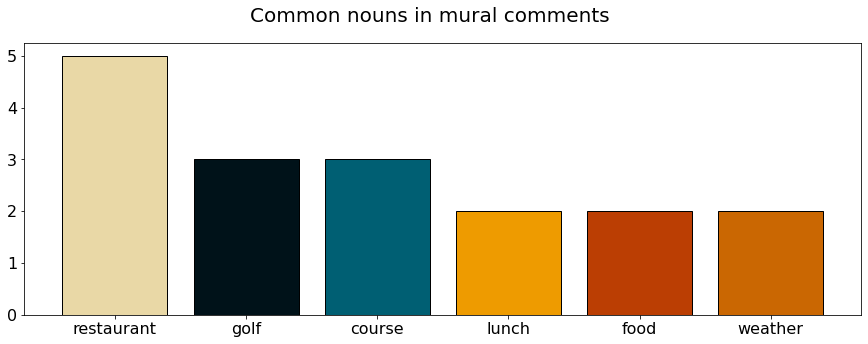

In [102]:
plot_words( "Common nouns in mural comments", common_nouns_od )